<a href="https://colab.research.google.com/github/vvadimmm/Quant/blob/main/vol_strat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Projet en cours
Trading volatilité: Ce notebook explore le trading de la volatilité via l’écart entre volatilité implicite (IV) et volatilité réalisée (RV). L’idée centrale est simple : le marché anticipe certains mouvements dans le prix des actifs à travers les options, ce qui se reflète dans la volatilité implicite. En comparant cette anticipation avec la volatilité réellement observée sur le sous-jacent, il est possible d’identifier des opportunités d’investissement ou d’arbitrage

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Calculate the start date for the last ten years
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

# Define the tickers for VIX and S&P500
vix_ticker = '^VIX'
sp500_ticker = '^GSPC'

# Download VIX data
print(f"Downloading VIX data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
vix_data = yf.download(vix_ticker, start=start_date, end=end_date)

# Download S&P500 data
print(f"Downloading S&P500 data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)

print("\nVIX Data Head:")
display(vix_data.head())

print("\nS&P500 Data Head:")
display(sp500_data.head())

/tmp/ipython-input-699418478.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_data = yf.download(vix_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-699418478.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



VIX Data Head:


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2016-01-11,24.299999,27.389999,23.830000,25.580000,0
2016-01-12,22.469999,23.930000,21.910000,22.969999,0
2016-01-13,25.219999,26.110001,21.440001,21.719999,0
2016-01-14,23.950001,26.280001,23.070000,24.750000,0
2016-01-15,27.020000,30.950001,26.670000,28.959999,0



S&P500 Data Head:


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2016-01-11,1923.670044,1935.650024,1901.099976,1926.119995,4607290000
2016-01-12,1938.680054,1947.380005,1914.349976,1927.829956,4887260000
2016-01-13,1890.280029,1950.329956,1886.410034,1940.339966,5087030000
2016-01-14,1921.839966,1934.469971,1878.930054,1891.680054,5241110000
2016-01-15,1880.329956,1916.680054,1857.829956,1916.680054,5468460000


In [ ]:
sp500_data["Close_log"]=np.log(sp500_data["Close"])
sp500_data["vix"]=vix_data["Close"]

In [ ]:
sp500_data["Log_ret"]=sp500_data["Close_log"].diff(1)
sp500_data["Log_ret_square"]=sp500_data["Log_ret"]**2

In [ ]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=20)

sp500_data["RV_forward"]=np.sqrt((252/20)*sp500_data["Log_ret_square"].rolling(window=indexer).sum())
sp500_data["RV_backward"]=np.sqrt((252/20)*sp500_data["Log_ret_square"].rolling(20).sum())

In [ ]:
sp500_data['signal']=(vix_data['Close']/100).subtract(sp500_data['RV_backward'],axis=0)
sp500_data["pnl"]=(vix_data['Close']/100).subtract(sp500_data['RV_forward'],axis=0)

In [ ]:
sp500_data["signal_dec"]=sp500_data["signal"].apply(lambda x: 1 if x>0.02 else 0)
sp500_data['pnl_real']=sp500_data["pnl"]*sp500_data["signal_dec"]

In [ ]:
window=sp500_data[20:-19]

In [ ]:
window

Price,Close,High,Low,Open,Volume,Close_log,Log_ret,Log_ret_square,RV_forward,pnl,RV_backward,signal,vix,signal_dec,pnl_real
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,,,,,,,
Date,,,,,,,,,,,,,,,
2016-02-09,1852.209961,1868.250000,1834.939941,1848.459961,5183220000,7.524135,-0.000664,4.406844e-07,0.173515,0.091885,0.228667,0.036733,26.540001,1,0.091885
2016-02-10,1851.859985,1881.599976,1850.319946,1857.099976,4471170000,7.523946,-0.000189,3.570895e-08,0.174419,0.088481,0.226998,0.035902,26.290001,1,0.088481
2016-02-11,1829.079956,1847.000000,1810.099976,1847.000000,5500800000,7.511568,-0.012377,1.532012e-04,0.174418,0.106982,0.213083,0.068317,28.139999,1,0.106982
2016-02-12,1864.780029,1864.780029,1833.400024,1833.400024,4696920000,7.530898,0.019330,3.736495e-04,0.178392,0.075608,0.216004,0.037996,25.400000,1,0.075608
2016-02-16,1895.579956,1895.770020,1871.439941,1871.439941,4570670000,7.547280,0.016382,2.683613e-04,0.164729,0.076371,0.209837,0.031263,24.110001,1,0.076371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02,6829.370117,6851.549805,6806.709961,6830.959961,4582290000,8.828988,0.002454,6.023202e-06,0.084544,0.081356,0.147833,0.018067,16.590000,0,0.000000
2025-12-03,6849.720215,6862.419922,6810.430176,6815.290039,4736780000,8.831963,0.002975,8.852770e-06,0.088085,0.072715,0.142162,0.018638,16.080000,0,0.000000


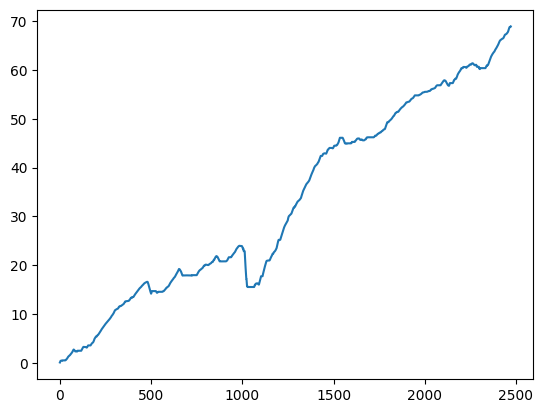

In [ ]:
plt.plot(range(len(window["pnl_real"].cumsum())),window["pnl_real"].cumsum())
